# Welcome to the GNN-Playground! 

This interactive notebook lets you explore Graph Neural Networks (GNNs) on tiny, cpu-friendly datasets.

---

**What you can explore:**
1. **Configure** your experiment using interactive widgets. 
2. **Run** the training loop to see live updating loss and accuracy plots. 
3. **Compare** previous and current configurations side-by-side and inspect final metrics.
4. **Generate** your __official__ GNN training certificate, to summarize all your training runs, honoring your final models and experiences you gained! 
5. **Share** your certificates in our Discussion Section on GitHub to get registered on our Playground Leaderboard!

---

Are you ready? Then **Set up your model** and hit `Run All` to get started!

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Add project root to path for local imports
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from utils.data import load_node_dataset, load_graph_dataset

seed = 42

### DATA

<div class="alert alert-block alert-info">
<b>KarateClub</b> 
Zachary (1977) recorded 34 karate club members social ties as it split due to some dispute. 
The resulting graph has 78 edges denoting friendships and community labels for the members, two groups around Mr. Hi (index 0) and John A (index 33).
KarateClub is an established Benchmark dataset and provides train/test masks for community detection.
</div>

<div class="alert alert-block alert-info">
<b>MUTAG</b> 
Debnath et al. (1977) collected 188 chemicals tested for mutagenicity. Our GNN is supposed to learn the underlying relationship between structure and activity of the compounds. Its a graph-classification benchmark with nodes representing atoms and edges representing chemical bonds.
</div>

Random seed at 42


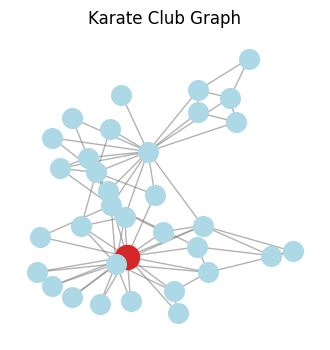

In [5]:
# Load the Karate Club dataset
# Reference: https://doi.org/10.1086/jar.33.4.3629752
karate = load_node_dataset("KarateClub", seed=seed)
G_karate = to_networkx(karate, to_undirected=True)

# Viz graph 
samples = [33]   # <- Choose members to highlight here

plt.figure(figsize=(4, 4))
pos = nx.spring_layout(G_karate, seed=seed)

nx.draw_networkx_nodes(
    G_karate, pos, 
    nodelist=samples,          
    node_color='tab:red', 
    node_size=300
    )
nx.draw_networkx_nodes(
    G_karate, pos, 
    nodelist=[n for n in G_karate.nodes if n not in samples],
    node_color='lightblue',
    node_size=200
    )
nx.draw_networkx_edges(
    G_karate, pos,
    edge_color='gray',
    alpha=0.6
    )
plt.title("Karate Club Graph")
plt.axis('off')
plt.show()

Random seed at 42
Number nodes: 17
Number edges: 38
Graph label y: 1
Node feature matrix shape: torch.Size([17, 7])
Edge attribute shape: torch.Size([38, 4])


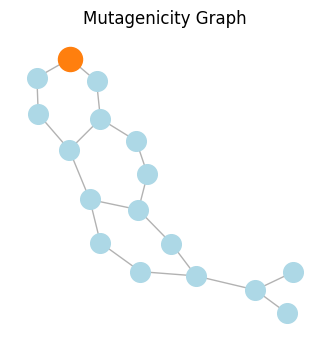

In [13]:
# Load data Chemical Mutagenicity dataset
# Reference: https://doi.org/10.1021/jm00106a046
train_loader, _ = load_graph_dataset("MUTAG", batch_size=1, shuffle=False)
mutag_sample = next(iter(train_loader))
G_mutag = to_networkx(mutag_sample, to_undirected=True)

# Display data
print(f"Number nodes: {mutag_sample.num_nodes}")
print(f"Number edges: {mutag_sample.num_edges}")
print(f"Graph label y: {mutag_sample.y.item()}")
print(f"Node feature matrix shape: {mutag_sample.x.size()}")
print(f"Edge attribute shape: {mutag_sample.edge_attr.size()}")

# Viz graph 
highlight_atom = [0]  # <- Choose atoms to highlight here

plt.figure(figsize=(4, 4))
pos = nx.spring_layout(G_mutag, seed=seed)
nx.draw_networkx_nodes(
    G_mutag, pos,
    nodelist=highlight_atom,
    node_color='tab:orange',
    node_size=300
    )
nx.draw_networkx_nodes(
    G_mutag, pos,
    nodelist=[n for n in G_mutag.nodes if n not in highlight_atom],
    node_color='lightblue',
    node_size=200
    )
nx.draw_networkx_edges(
    G_mutag, pos,
    edge_color='gray',
    alpha=0.6
    )
plt.title("Mutagenicity Graph")
plt.axis('off')
plt.show()

In [ ]:
# def ...